In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '/mnt/c/Users/phoen/Documents/GitHub/spateo-release')

import matplotlib.pyplot as plt
import numpy as np
import skimage
import sklearn
import spateo as st

plt.style.use('default')
plt.rcParams['image.interpolation'] = 'none'
%config InlineBackend.figure_format='retina'

/home/lioscro/miniconda3/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/home/lioscro/miniconda3/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper
/home/lioscro/miniconda3/lib/python3.8/site-packages/spaghetti/network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and opera

In [2]:
%%time
adata = st.io.read_bgi_agg(
    '/mnt/e/scratch/stereo/SS200000135TL_D1_Intron_Bin1.txt.gz',
    '/mnt/e/scratch/stereo/SS200000135IL-D1_mrna.matched.ssDNA.tif',
    scale=0.5,
    scale_unit='um',
    gene_agg={'nuclear': ['Malat1']}
)[3000:14000,6000:20000].copy()
adata

CPU times: user 47.9 s, sys: 4.46 s, total: 52.4 s
Wall time: 1min


AnnData object with n_obs × n_vars = 11000 × 14000
    uns: '__type', 'pp', 'spatial'
    layers: 'stain', 'spliced', 'unspliced', 'nuclear'

## Stain

In [3]:
%%time
st.pp.segmentation.refine_alignment(adata, mode='rigid', transform_layers=['stain'], downscale=0.5)

Loss -2.6462e-03: 100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


CPU times: user 9min 34s, sys: 2min, total: 11min 35s
Wall time: 1min 56s


In [4]:
%%time
st.pp.segmentation.mask_nuclei_from_stain(adata)

CPU times: user 3min 2s, sys: 689 ms, total: 3min 3s
Wall time: 3min 3s


In [5]:
%%time
st.pp.segmentation.watershed_markers(adata)

CPU times: user 21.3 s, sys: 11.3 s, total: 32.6 s
Wall time: 3.1 s


In [6]:
%%time
st.pp.segmentation.watershed(adata)

CPU times: user 21.5 s, sys: 1.46 s, total: 23 s
Wall time: 21.2 s


In [7]:
%%time
st.pp.segmentation.mask_cells_from_stain(adata, out_layer='stain_cell_mask')

CPU times: user 848 ms, sys: 61 ms, total: 909 ms
Wall time: 908 ms


In [8]:
%%time
st.pp.segmentation.watershed(
    adata,
    mask_layer='stain_cell_mask',
    markers_layer='stain_labels',
    out_layer='cell_labels',
)

CPU times: user 40.9 s, sys: 692 ms, total: 41.6 s
Wall time: 41.6 s


In [20]:
%%time
st.pp.segmentation.expand_labels(adata, 'cell_labels', distance=2, max_area=np.inf, out_layer='cell_labels_expanded')

CPU times: user 3min, sys: 429 ms, total: 3min
Wall time: 3min


## RNA

In [10]:
%%time
st.pp.segmentation.score_and_mask_pixels(
    adata, 'nuclear', k=13, method='EM+BP',
    em_kwargs=dict(downsample=0.001, seed=2022), bp_kwargs=dict(n_threads=16),
    mk=3  # Expected to be small
)

Running EM: 100%|##########| 1/1 [01:13<00:00, 73.25s/it]


CPU times: user 4min 44s, sys: 10.3 s, total: 4min 54s
Wall time: 2min 52s


In [11]:
%%time
st.pp.segmentation.label_connected_components(adata, 'nuclear')

CPU times: user 49.8 s, sys: 16.5 s, total: 1min 6s
Wall time: 27.2 s


CPU times: user 4min 20s, sys: 4.02 s, total: 4min 24s
Wall time: 4min 22s


(<Figure size 400x400 with 1 Axes>,
 <AxesSubplot:title={'center':'unspliced_bins'}, xlabel='um', ylabel='um'>)

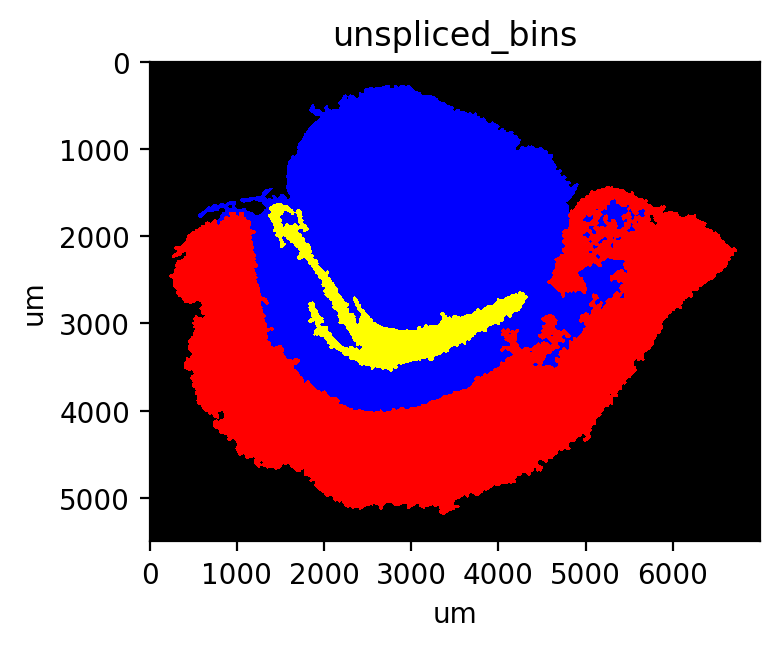

In [12]:
%%time
st.pp.segmentation.segment_densities(adata, 'unspliced', 10, k=7, dk=5, distance_threshold=6)
st.pl.imshow(adata, 'unspliced_bins', labels=True)

In [13]:
%%time
st.pp.segmentation.score_and_mask_pixels(
    adata, 'unspliced', k=13, method='EM+BP',
    em_kwargs=dict(downsample=0.001, seed=2022), bp_kwargs=dict(n_threads=16),
    certain_layer='nuclear_labels'
)

Running EM: 100%|##########| 3/3 [00:16<00:00,  5.40s/it]


CPU times: user 6min, sys: 8.7 s, total: 6min 9s
Wall time: 3min 11s


In [14]:
%%time
st.pp.segmentation.label_connected_components(adata, 'unspliced', seed_layer='nuclear_labels')

CPU times: user 1min 18s, sys: 20.5 s, total: 1min 38s
Wall time: 49.6 s


CPU times: user 4min 3s, sys: 2.69 s, total: 4min 6s
Wall time: 4min 5s


(<Figure size 400x400 with 1 Axes>,
 <AxesSubplot:title={'center':'X_bins'}, xlabel='um', ylabel='um'>)

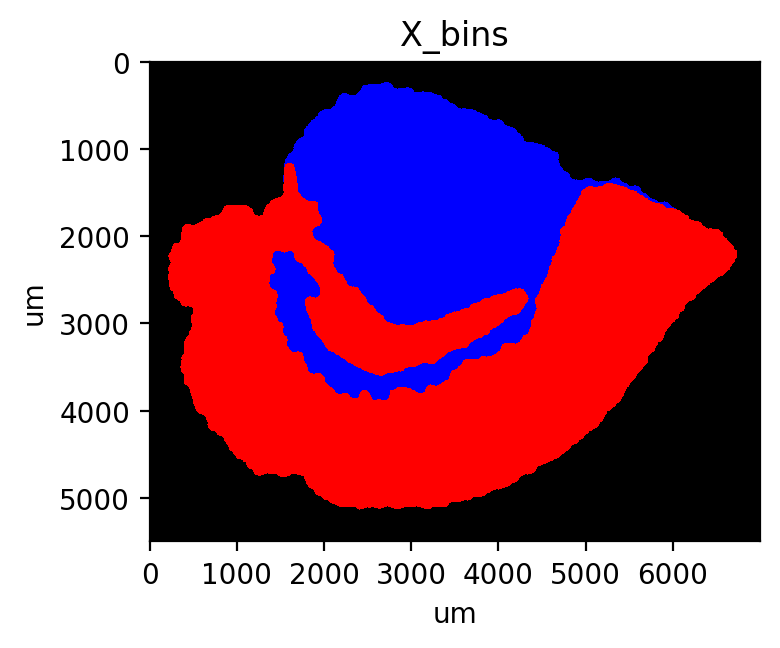

In [15]:
%%time
st.pp.segmentation.segment_densities(adata, 'X', 10, k=5, distance_threshold=20, dk=21)
st.pl.imshow(adata, 'X_bins', labels=True)

In [16]:
%%time
st.pp.segmentation.score_and_mask_pixels(
    adata, 'X', k=15, method='EM+BP',
    em_kwargs=dict(downsample=0.001, seed=2022), bp_kwargs=dict(n_threads=16),
    certain_layer='unspliced_labels'
)

Running EM: 100%|##########| 2/2 [00:34<00:00, 17.34s/it]


CPU times: user 5min 39s, sys: 8.69 s, total: 5min 48s
Wall time: 3min 16s


In [17]:
%%time
st.pp.segmentation.expand_labels(
    adata, 'unspliced', distance=5, max_area=400, mask_layer='X_mask', out_layer='X_labels'
)

CPU times: user 8min 32s, sys: 1.29 s, total: 8min 34s
Wall time: 8min 32s


In [21]:
%%time
st.pp.segmentation.expand_labels(adata, 'X', distance=2, max_area=np.inf, out_layer='X_labels_expanded')

CPU times: user 3min 19s, sys: 678 ms, total: 3min 20s
Wall time: 3min 19s


In [ ]:
adata.write('data/full_segmentation.h5ad', compression='gzip')